## Analyze A/B Test Results

By Julio Uribe

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to practice working with the difficulties of these.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [29]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [30]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [31]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [32]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [33]:
#check the type for converted column value
type(df["converted"][0])
#we can use .mean() to find proportion
df["converted"].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [34]:
treat_notNew = df.query("group == 'treatment' and landing_page == 'old_page'").shape[0]
new_notTreat = df.query("group == 'control' and landing_page == 'new_page'").shape[0]
treat_notNew + new_notTreat

3893

f. Do any of the rows have missing values?

In [35]:
#data set is clean. no missing values in any row
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [36]:
# we'll grab the rows where control/old and treatment/new line up properly
# and append them into a new df called df2
df_treat_new = df.query("group == 'treatment' and landing_page == 'new_page'")
df_control_old = df.query("group == 'control' and landing_page == 'old_page'")
df2 = df_treat_new.append(df_control_old)

In [37]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [38]:
#number of unique users and total users for reference
df2['user_id'].nunique(), df2.shape[0]

(290584, 290585)

b. There is one **user_id** repeated in **df2**.  What is it?

In [39]:
#confirm there is one repeated user
print(df2['user_id'].duplicated().sum())
#print out row for duplicated user id
df2[df2['user_id'].duplicated()]

1


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [40]:
#query the rows where user id matches above user id to see both rows
df2.query("user_id == '773192'")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [41]:
#print length of df2 before and after removing desired row
df2.drop([2893], inplace=True)
df2.query("user_id == '773192'")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [42]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [43]:
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [44]:
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [45]:
#heres the proportion of users that received treatment/new page
df2.query("group == 'treatment'").shape[0]/df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

The probabilty difference between the two groups right now is about 0.0005. This doesn't seem like a significant difference but further analysis will give us more clear results.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Allowing a Type 1 error rate of 5%, our hypotheses are as follows

**$H_{0}$** - our null hypothesis is that **$p_{new}$** is less than or equal to **$p_{old}$**

**$H_{1}$** - our alternative hypothesis is that **$p_{new}$** is greater than **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [46]:
#since the null hypothesis assumes they are equal we use the conversion
#rate for the whole data set not filtering for new/old
p_new = df['converted'].mean()
p_new

0.11965919355605512

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [47]:
#since the null hypothesis assumes they are equal we use the conversion
#rate for the whole data set not filtering for new/old
p_old = df['converted'].mean()
p_old

0.11965919355605512

c. What is $n_{new}$?

In [48]:
#using df2 which is our clean df where we removed duplicates and mismatches
n_new = df2.query("group == 'treatment'").shape[0]
print ("The number of users in the treatment group are", n_new)

The number of users in the treatment group are 145310


d. What is $n_{old}$?

In [49]:
#using df2 which is our clean df where we removed duplicates and mismatches
n_old = df2.query("group == 'control'").shape[0]
print("The number of users in the control group are", n_old)

The number of users in the control group are 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [50]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17474

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [51]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17536

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [52]:
p_diff = p_new-p_old
p_diff

0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [53]:
#simulating 10,000 values of p_new - p_old
#using this in place of bootstrapping as suggested by instructor feedback. p_old and p_new are relatively equal as
#calculated above assuming the null is true. Result is very tiny
p_diffs = np.random.binomial(n_new, p_new, 10000)/n_new - np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs.mean()

1.0414779265656912e-05

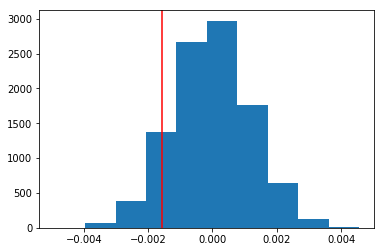

In [55]:
#we chose the mean of null values as zero because under our null statement, there should be 0 difference between
#new_conv_rate and old_conv_rate. Now we create a normal distribution of null values to determine p-value for obs_diff
null_vals = np.random.normal(0, np.array(p_diffs).std(), len(p_diffs))
obs_diff = df2.query("group == 'treatment'")['converted'].mean() - df2.query("group == 'control'")['converted'].mean()
print ("Proportion Greater : {}".format((np.array(null_vals) > obs_diff).mean()), end = "\r")
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');

In [56]:
np.mean(p_diffs)

1.0414779265656912e-05

We simulated 10,000 instances of calculating p_diff under the null and got a really small value for p_diffs. We used this to simulate a normal distribution under our null assuming that there is no difference in either page so our mean value was set to 0. By plotting the histogram using the null values, we can easily compare our observed difference versus a distribution of null values to determine if the observed difference we noticed would occur by chance. Our result shows that the new page performed worse with 90.75% confidence. We initially set up a one tailed test that the new page would perform better and got a p value of ~ 0.9 that this didn't occur by chance. However, this went the opposite way of what we predicted and it isn't outside our p-critical value range to be significant enough statistically to reject the null. From our findings here, we would fail to reject the null.

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

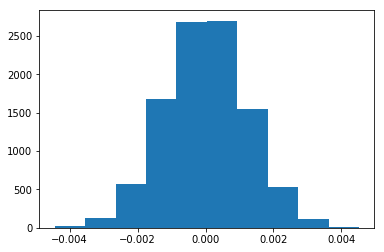

In [57]:
plt.hist(p_diffs);

With what we learned from above, I would say this is consistent with our findings so far. We've noticed there's a small difference that the new page performs slightly worse. Our histogram of p_diffs shows a normal distribution centered around a small negative value around -0.002.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [58]:
(p_diffs > obs_diff).mean()

0.9072

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

After running 10,000 simulations of p_new - p_old, we compared p_diffs against the observed difference. Calculating **p_diffs > obs_diff** we got a **p-value of ~0.9**. With our one tail test and a type 1 error threshold of 5%, we determine that this value isn't significant enough and it could have occurred by chance. This is the value we should use to determine if we would recommend using the new page. As a result, we recommend that **we fail to reject the null**.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [59]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control' and converted == 1").shape[0]
convert_new = df2.query("group == 'treatment' and converted == 1").shape[0]
n_old = df2.query("group == 'control'").shape[0]
n_new = df2.query("group == 'treatment'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [60]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In order to be consistent with our setup of our null and alternative hypothesis, we need to set up a one-sided test to evaluate if the new page is better than the old page. We set up our z-test to ask if the conversion rate for the new page is better than the conversion rate of the old page. We end up with a z-value showing us that the new page performs slightly worse than the old page with a z-stat of -1.3. With a p-value of 0.9, we can't determine that there is a statiscal difference between the two pages and we fail to reject the null.

These findings are consistent to our findings in j. and k. We got a p-value of ~0.9 both times and found that the new page was performing slightly worse than the old page both times. With our z-statistic inside our 95% confidence interval, we fail to reject the null using boot strapping methods, and with the built in z-test function.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since each row is either a conversion or no conversion represented with 0's and 1's we'll want to use a logistic regression model.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [61]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [62]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [63]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:39:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>

The **p-value associated with the ab_page is 0.190**. The difference lies in our hypothesis assumptions of the test. With this regression model, the p-value is given assuming a **two tailed test. If we divide our p-value (0.190) by 2, we get 0.095 which resembles the one tail test** we did in part 2 so our findings are consistent. The only difference is the regression model is giving us a p-value in the context of a two-tailed test vs our one sided test earlier.

In [64]:
0.190/2

0.095

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Perhaps would could add group as a predictor to see if we get a p-value more similar to what we found through previous calculations before using the logistic regression algorithm. We also don't have too much information about the users who were put into the different groups. It would be interesting to have more data such as whether they are already enrolled in a class, what country they're logging in from, etc.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [65]:
country_data = pd.read_csv('countries.csv')
country_data.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [66]:
#check if the unique users match so we know which join type to use
country_data['user_id'].nunique(), df2['user_id'].nunique()

#join the two data sets
df_combo = pd.merge(df2, country_data[['user_id', 'country']], on = 'user_id')
df_combo.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,CA


In [67]:
#unique values from country column
df_combo.country.unique()
#some totals
df_combo.query("country == 'US'").shape[0], df_combo.query("country == 'UK'").shape[0], df_combo.query("country == 'CA'").shape[0]
df_combo.query("country == 'US'")['converted'].mean()
df_combo.query("country == 'UK'")['converted'].mean()
df_combo.query("country == 'CA'")['converted'].mean()

0.11531829781364232

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [68]:
df_combo[['CA', 'UK', 'US']] = pd.get_dummies(df_combo['country'])
df_combo.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,CA,1,0,0


In [69]:
df_combo = df_combo.drop('US', axis = 1)

In [70]:
#create logistic model using countries as predictor varialbes. US is baseline
logit_mod2 = sm.Logit(df_combo['converted'], df_combo[['intercept', 'ab_page', 'CA', 'UK']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 17 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        18:39:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Country Data Conclusion**

I added country data. I looked at individual conversion rates before building the regression model and the diffs were fairl small similar to what we saw earlier in our report. I made dummy variables out of the 'country' column so I could build a logistic regression model using 'country' as a predictor variable with US as my baseline. The result is p-values that were not statistically significant. Every p-value was outside of our Type 1 Error threshold so we still fail to reject the null. We cannot recommend using the new page over the old page.